#### Import Packages

In [23]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

np.random.seed(123)

## Data:

In [24]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')  

In [25]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}
#Read File csv
skin_df = pd.read_csv('HAM10000_metadata.csv')
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [26]:
skin_df['image_id']

0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object

In [27]:
skin_df_balanced = skin_df.sample(n=500,replace=False, random_state=1)

image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('*', '*.jpg'))}
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

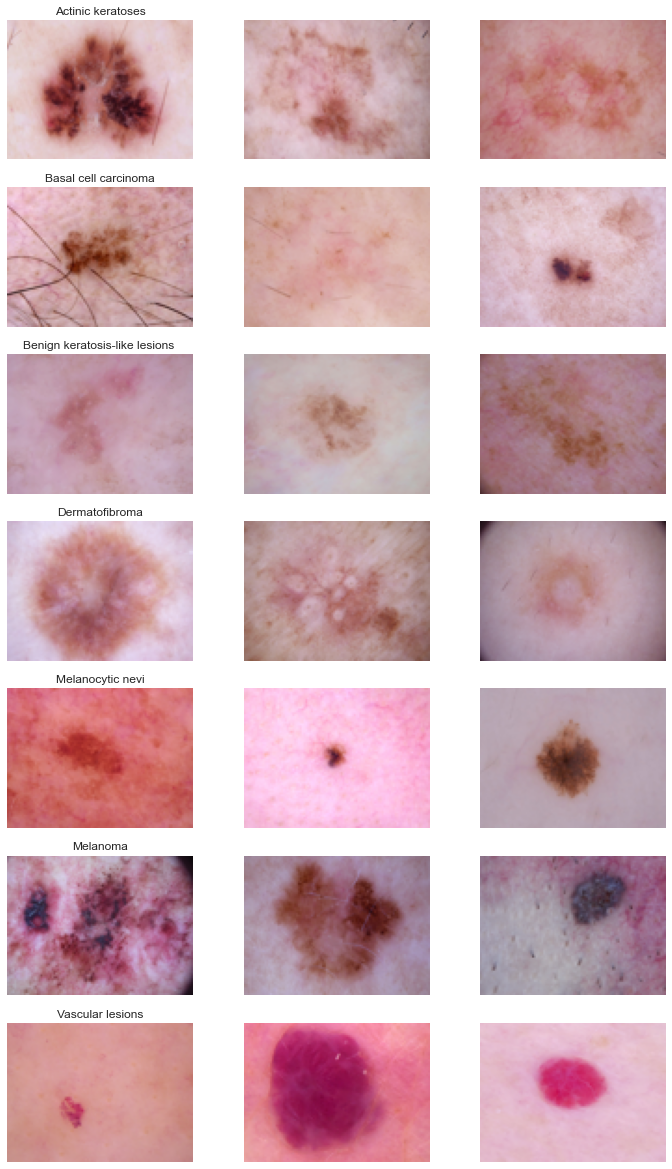

In [28]:
#img = skin_df.sample(n=500,replace=False, random_state=1)
#img['image'] = img['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
#Image Sampling
n_samples = 3

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))

for n_axs, (type_name, type_rows) in zip(m_axs,skin_df_balanced.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [29]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 11,
Duplicated Entries: 0,
Null Entries: 10072,
Number of Rows with Null Entries: 10015 100.0%


In [30]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,dataset,object,0,4
8,path,object,10015,0
9,cell_type,object,0,7


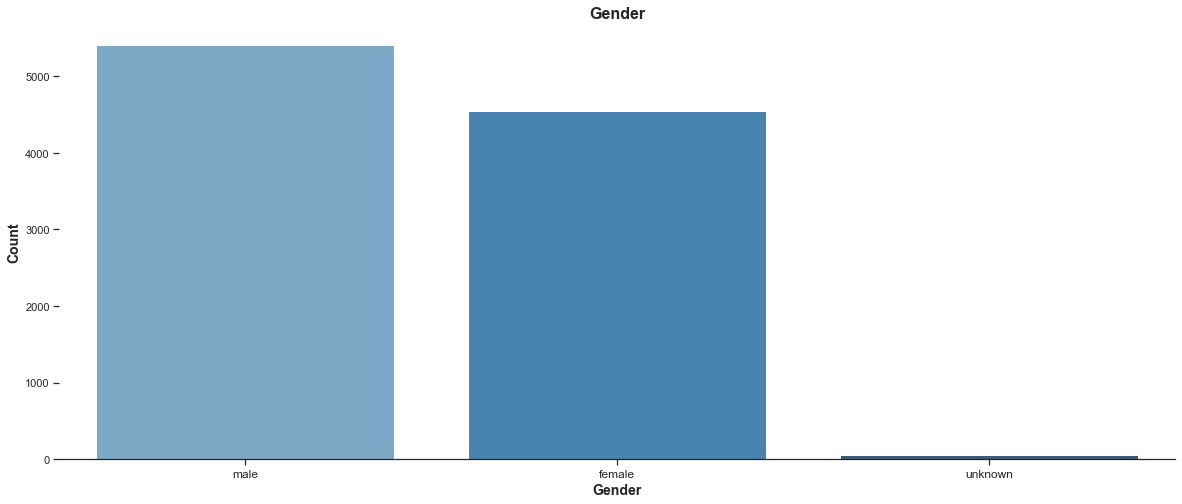

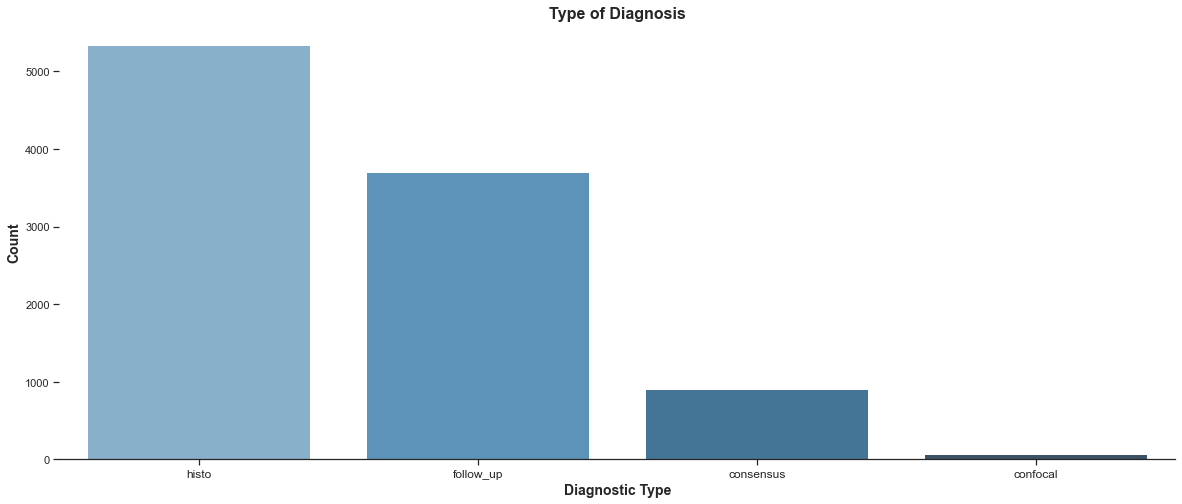

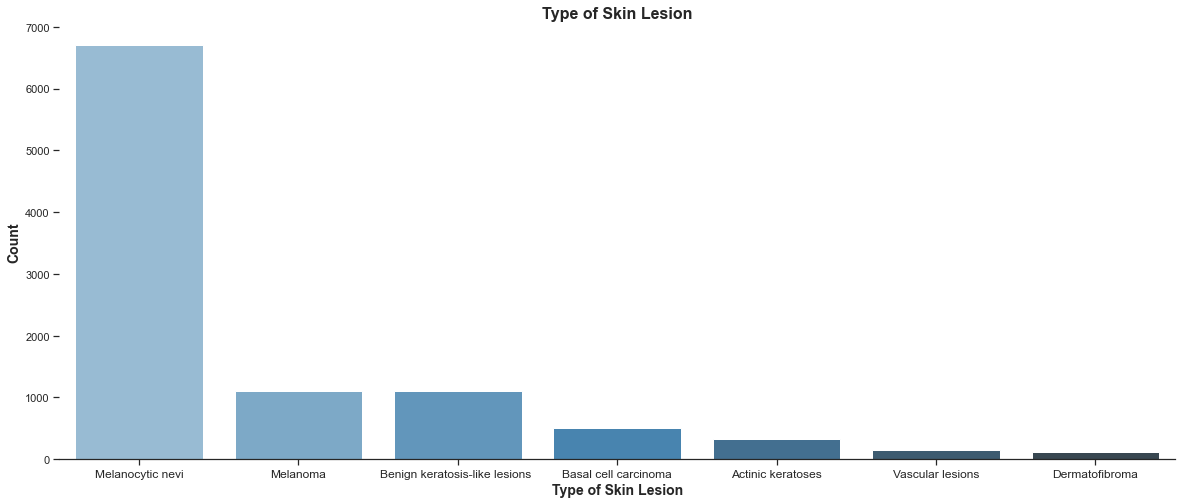

In [82]:
countplot(skin_df,'sex', 'Gender', 'Count', 'Gender')
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Type of Skin Lesion')

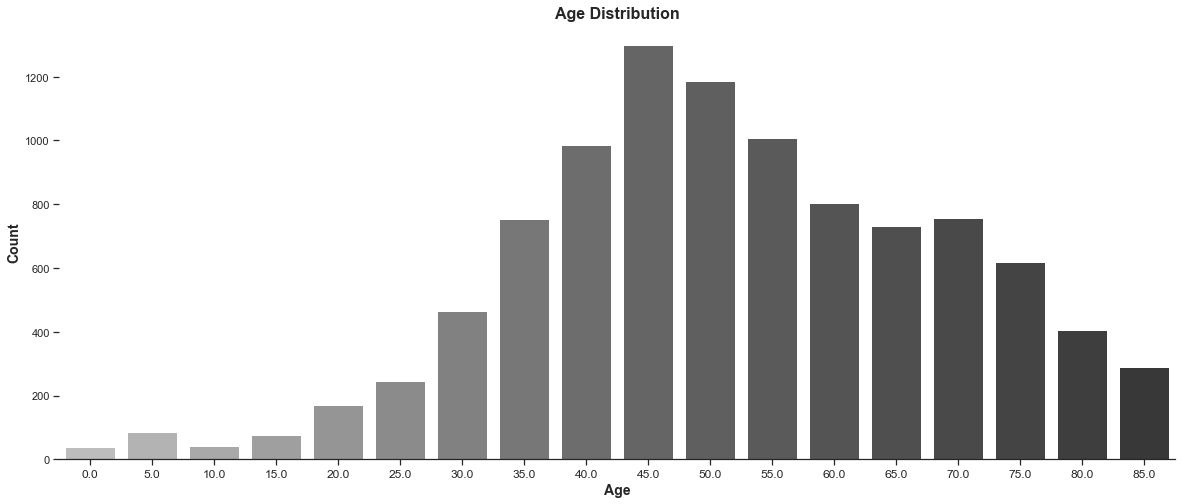

In [83]:
skin_df['age'].fillna((skin_df['age'].mode()), inplace=True)

plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_df,x='age',palette="Greys_d")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution', fontsize = 16,weight = 'bold');

#### Melanoma Deep Dive

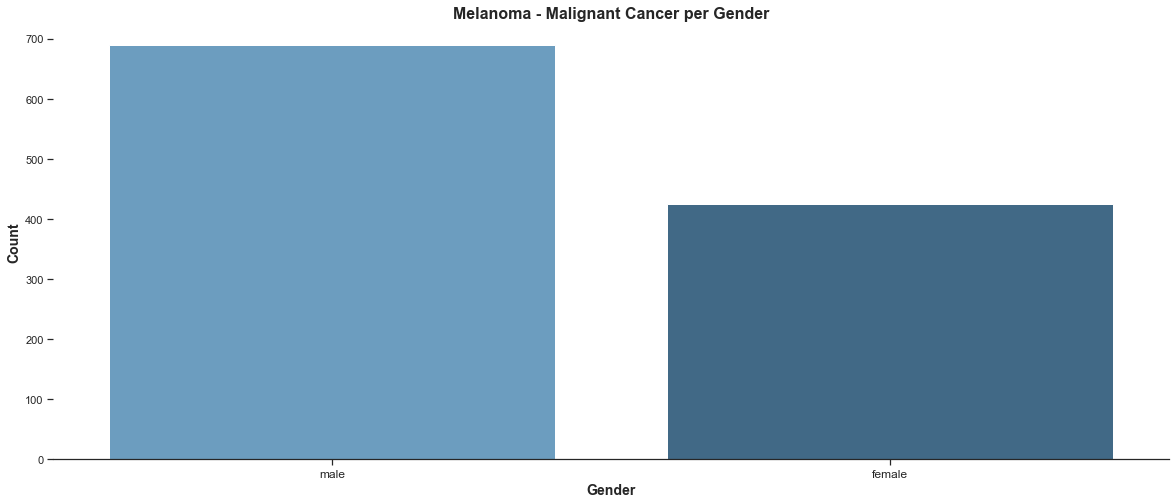

In [33]:
skin_mel = skin_df.loc[:,['age','sex','localization','cell_type']]
skin_mel = skin_mel[skin_mel['cell_type'] == 'Melanoma']

countplot(skin_mel,'sex', 'Gender', 'Count', 'Melanoma - Malignant Cancer per Gender')

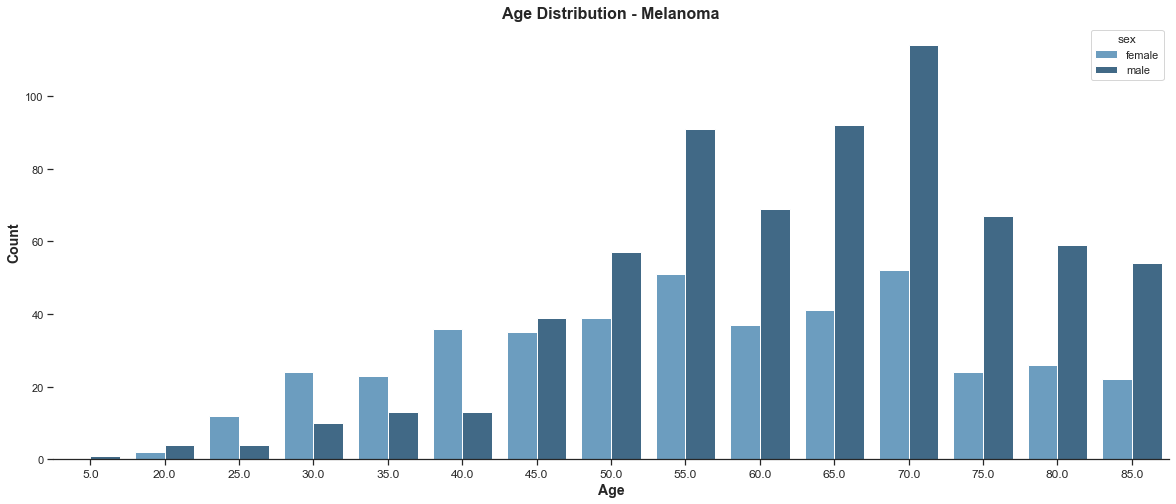

In [34]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = skin_mel,x='age',palette="Blues_d", hue = 'sex')
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
plt.title('Age Distribution - Melanoma', fontsize = 16,weight = 'bold');

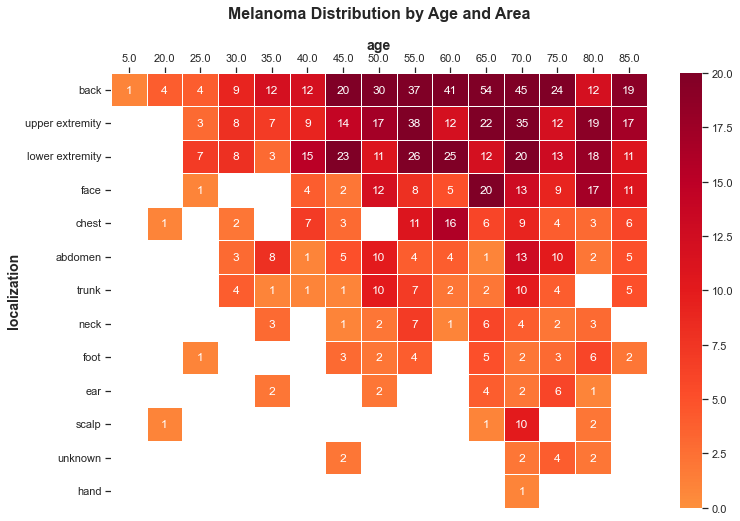

In [51]:
skin_local = skin_mel.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
skin_local.columns = ['localization', 'count']
sort_by = skin_local['localization']

skin_heat = skin_mel.groupby(['age','localization']).size().reset_index()
skin_heat.columns = ['age', 'localization', 'count']
skin_heat.sort_values('count', ascending=False, inplace=True)

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlOrRd", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')    
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()
    
heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Melanoma Distribution by Age and Area')

## CNNs

### Set up Data Frame for Processing

In [19]:
#skin_df_balanced = skin_df.sample(n=500,replace=False, random_state=1)
skin_df2 = skin_df
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('*', '*.jpg'))}
skin_df2['path'] = skin_df['image_id'].map(image_path.get)
skin_df2['image'] = skin_df2['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

### Train/Test/Validate Split

In [20]:
#skin_df2['image'] = skin_df2['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

features=skin_df2.drop(columns=['cell_type_idx'],axis=1)
target=skin_df2['cell_type_idx']

# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)

#The normalisation is done using the training set Mean and Std. Deviation as reference
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)

#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

## Manual CNN #1 (improved from Base CNN)

In [21]:
#Model Parameters
input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100
batch_size = 20

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)

def history(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    return (predictions,accuracy_t,accuracy_v,accuracy)

/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

y_pred, accuracy_t,accuracy_v,accuracy = history(model)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

2022-05-23 11:50:56.774890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


63/63 [==============================] - 5s 82ms/step
Training: accuracy = 0.789598
Validation: accuracy = 0.780549
Test: accuracy = 0.755367


In [53]:
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))

Training: accuracy = 0.789598
Validation: accuracy = 0.780549
Test: accuracy = 0.755367


In [84]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

In [85]:
categories = ['Actinic keratoses', 'Basal cell carcinoma','Benign keratosis-like lesions ', 'Dermatofibroma', 
              'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

In [86]:
CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index=categories)

In [87]:
CMatrix

,Actinic keratoses,Basal cell carcinoma,Benign keratosis-like lesions,Dermatofibroma,Melanocytic nevi,Melanoma,Vascular lesions
Actinic keratoses,27,15,6,1,14,1,0
Basal cell carcinoma,11,63,2,5,17,1,1
Benign keratosis-like lesions,10,10,94,3,94,14,0
Dermatofibroma,1,7,1,10,5,0,0
Melanocytic nevi,11,17,20,2,1243,21,6
Melanoma,14,8,10,1,147,57,3
Vascular lesions,1,5,0,0,4,1,19


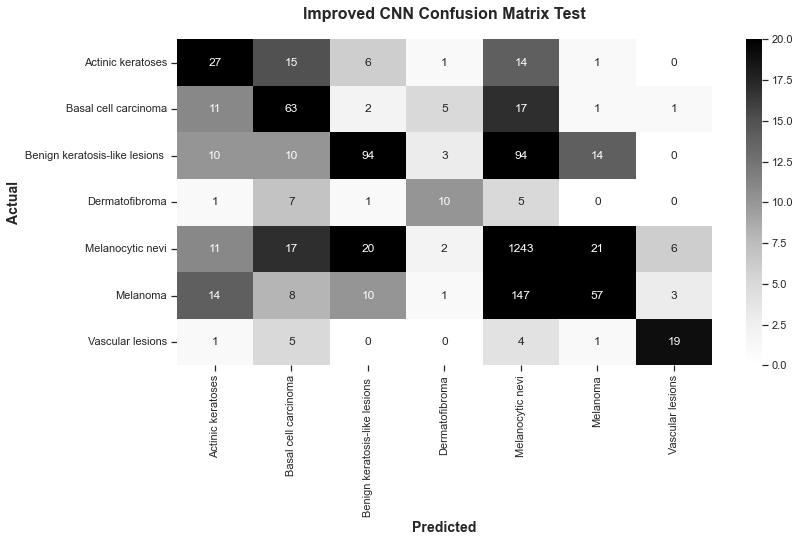

In [88]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Greys')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('Improved CNN Confusion Matrix Test',fontsize = 16,weight = 'bold',pad=20);

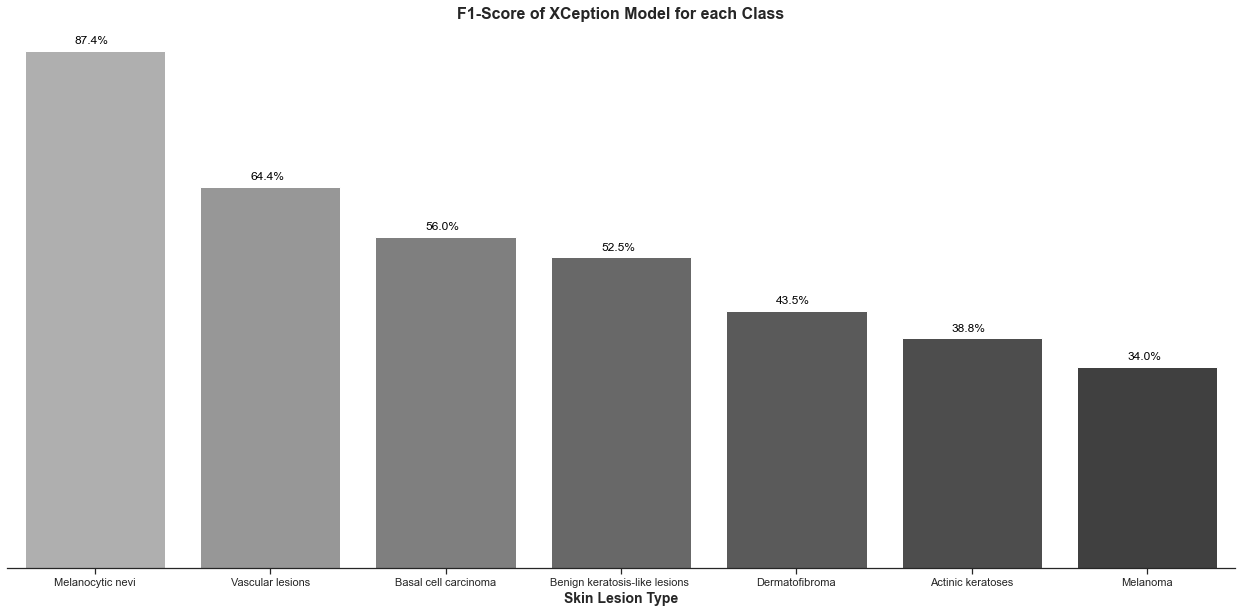

In [89]:
f1 = f1_score(y_test_o, predictions, average=None)
index = categories
f1_df = pd.DataFrame(f1,index, columns = ['F1'])
f1_df.sort_values(['F1'], ascending = False, inplace = True)

plt.figure(figsize=(22,10))
ax = sns.barplot(data =f1_df, x=f1_df.index, y = 'F1',palette = "Greys_d")
#Bar Labels
for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
sns.despine(top=True, right=True, left=True, bottom=False)
ax.set_xlabel('Skin Lesion Type',fontsize = 14,weight = 'bold')
ax.set_ylabel('F1-Score',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title("F1-Score of XCeption Model for each Class", fontsize = 16,weight = 'bold');

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test_o,predictions))

              precision    recall  f1-score   support

           0       0.36      0.42      0.39        64
           1       0.50      0.63      0.56       100
           2       0.71      0.42      0.53       225
           3       0.45      0.42      0.43        24
           4       0.82      0.94      0.87      1320
           5       0.60      0.24      0.34       240
           6       0.66      0.63      0.64        30

    accuracy                           0.76      2003
   macro avg       0.59      0.53      0.54      2003
weighted avg       0.74      0.76      0.73      2003



## ResNet50 CNN

In [41]:
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))
###################################

for layer in base_model.layers:
    layer.trainable = True

ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50accuracy))

63/63 [==============================] - 12s 175ms/step
ResNet50 Training: accuracy = 0.790985
ResNet50 Validation: accuracy = 0.771820
ResNet50 Test: accuracy = 0.762856


In [91]:
predictions = np.array(list(map(lambda x: np.argmax(x), ResNet50y_pred)))

In [92]:
categories = ['Actinic keratoses', 'Basal cell carcinoma','Benign keratosis-like lesions ', 'Dermatofibroma', 
              'Melanocytic nevi', 'Melanoma', 'Vascular lesions']

In [93]:
CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index=categories)

In [94]:
CMatrix

,Actinic keratoses,Basal cell carcinoma,Benign keratosis-like lesions,Dermatofibroma,Melanocytic nevi,Melanoma,Vascular lesions
Actinic keratoses,22,10,15,0,14,3,0
Basal cell carcinoma,16,54,9,0,20,1,0
Benign keratosis-like lesions,7,13,97,0,96,12,0
Dermatofibroma,1,9,4,1,9,0,0
Melanocytic nevi,2,8,20,0,1282,6,2
Melanoma,5,2,20,0,158,55,0
Vascular lesions,2,0,0,0,11,0,17


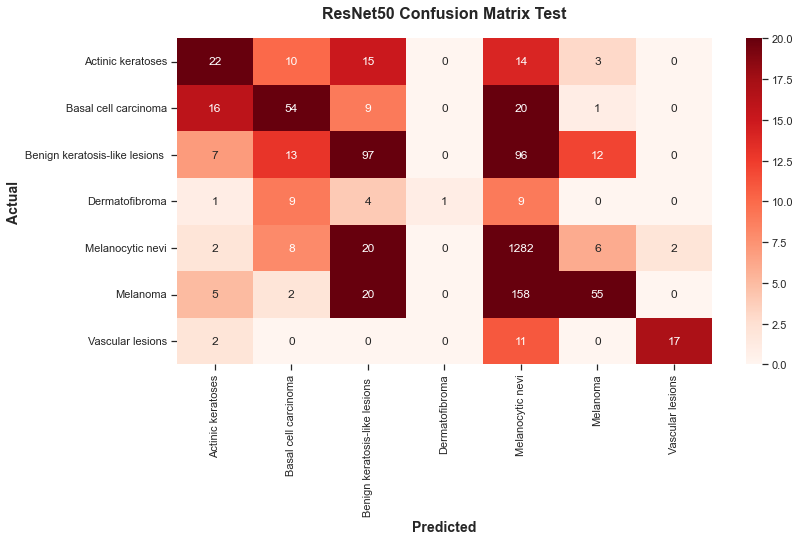

In [95]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Reds')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('ResNet50 Confusion Matrix Test',fontsize = 16,weight = 'bold',pad=20);

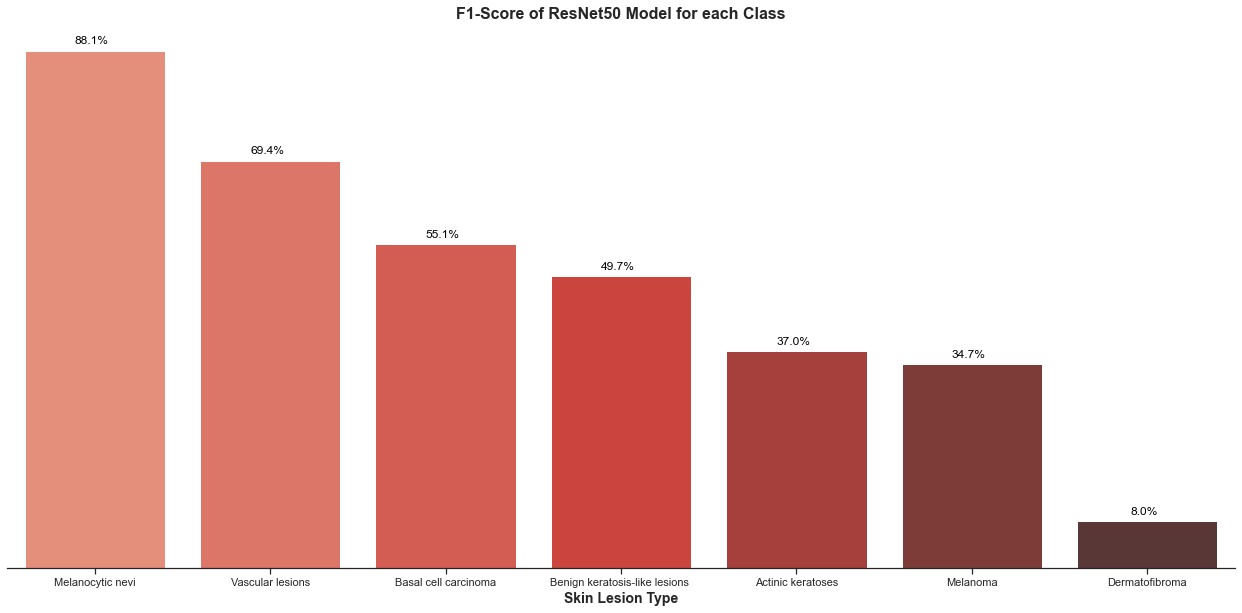

In [96]:
f1 = f1_score(y_test_o, predictions, average=None)
index = categories
f1_df = pd.DataFrame(f1,index, columns = ['F1'])
f1_df.sort_values(['F1'], ascending = False, inplace = True)

plt.figure(figsize=(22,10))
ax = sns.barplot(data =f1_df, x=f1_df.index, y = 'F1',palette = "Reds_d")
#Bar Labels
for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
sns.despine(top=True, right=True, left=True, bottom=False)
ax.set_xlabel('Skin Lesion Type',fontsize = 14,weight = 'bold')
ax.set_ylabel('F1-Score',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title("F1-Score of ResNet50 Model for each Class", fontsize = 16,weight = 'bold');

In [97]:
from sklearn.metrics import classification_report
print(classification_report(y_test_o,predictions))

              precision    recall  f1-score   support

           0       0.40      0.34      0.37        64
           1       0.56      0.54      0.55       100
           2       0.59      0.43      0.50       225
           3       1.00      0.04      0.08        24
           4       0.81      0.97      0.88      1320
           5       0.71      0.23      0.35       240
           6       0.89      0.57      0.69        30

    accuracy                           0.76      2003
   macro avg       0.71      0.45      0.49      2003
weighted avg       0.75      0.76      0.73      2003



## XCeption CNN

In [48]:
training_shape = (75,100, 3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)

XCeptionmodel = base_model.output
XCeptionmodel = Flatten()(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionmodel = Dense(128, activation='relu')(XCeptionmodel)
XCeptionmodel = Dropout(0.2)(XCeptionmodel)

XCeptionmodel = BatchNormalization()(XCeptionmodel)
XCeptionoutput = Dense(num_classes, activation = 'softmax')(XCeptionmodel)
XCeptionmodel = Model(inputs=base_model.input, outputs=XCeptionoutput)

for layer in base_model.layers:
    layer.trainable = True

XCeptiony_pred,XCeptionaccuracy_t,XCeptionaccuracy_v,XCeptionaccuracy = history(XCeptionmodel)
    
print("XCeption Training: accuracy = %f" % (XCeptionaccuracy_t))
print("XCeption Validation: accuracy = %f" % (XCeptionaccuracy_v))
print("XCeption Test: accuracy = %f" % (XCeptionaccuracy))

83683744/83683744 [==============================] - 1s 0us/step


63/63 [==============================] - 9s 140ms/step
XCeption Training: accuracy = 0.889598
XCeption Validation: accuracy = 0.817955
XCeption Test: accuracy = 0.814279


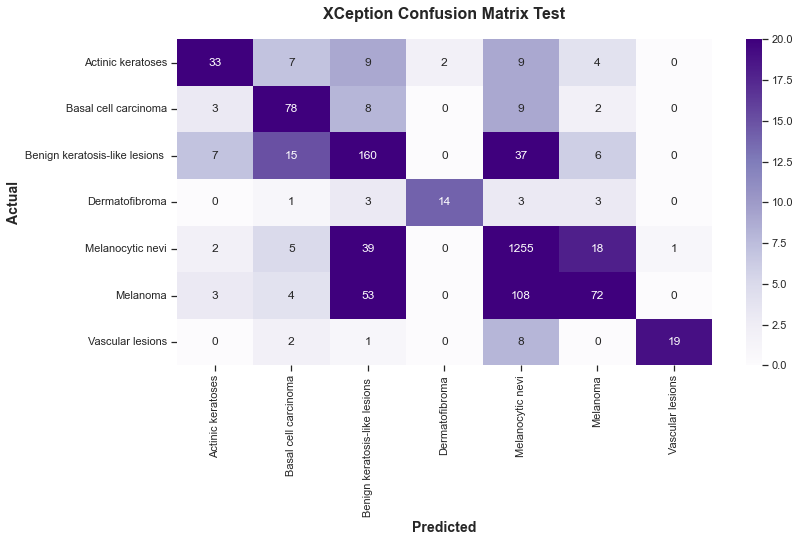

In [98]:
predictions = np.array(list(map(lambda x: np.argmax(x), XCeptiony_pred)))
categories = ['Actinic keratoses', 'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi',
              'Melanoma', 
              'Vascular lesions']

CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index =categories)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Purples')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('XCeption Confusion Matrix Test',fontsize = 16,weight = 'bold',pad=20);

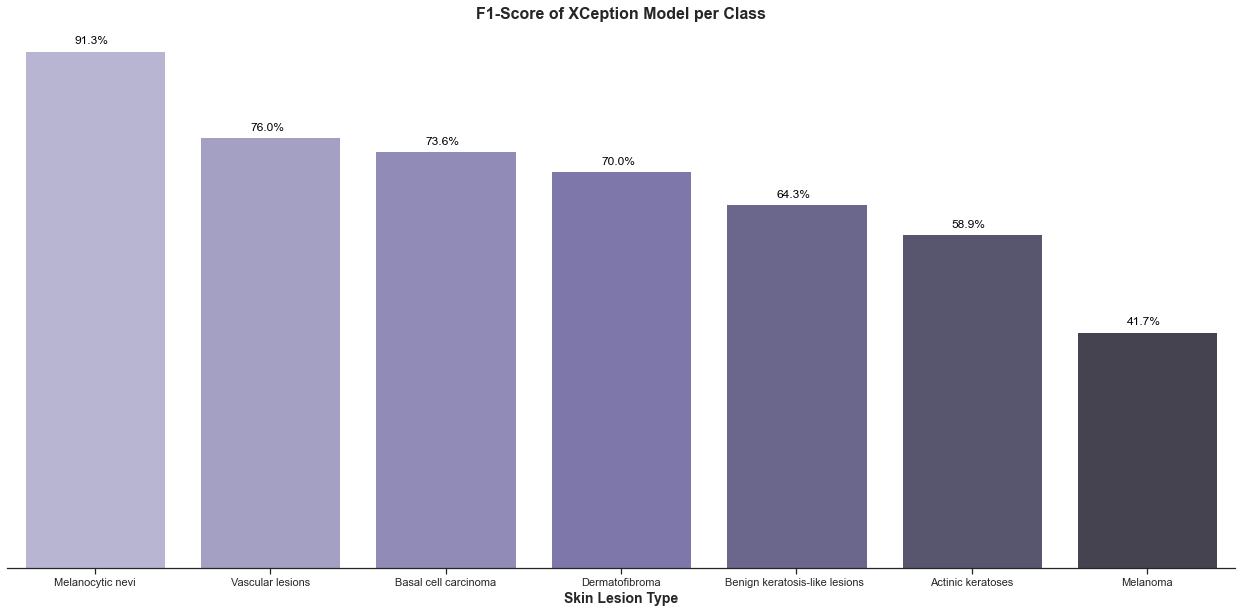

In [99]:
f1 = f1_score(y_test_o, predictions, average=None)
index = categories
f1_df = pd.DataFrame(f1,index, columns = ['F1'])
f1_df.sort_values(['F1'], ascending = False, inplace = True)

plt.figure(figsize=(22,10))
ax = sns.barplot(data =f1_df, x=f1_df.index, y = 'F1',palette = "Purples_d")
#Bar Labels
for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
sns.despine(top=True, right=True, left=True, bottom=False)
ax.set_xlabel('Skin Lesion Type',fontsize = 14,weight = 'bold')
ax.set_ylabel('F1-Score',fontsize = 14,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title("F1-Score of XCeption Model per Class", fontsize = 16,weight = 'bold');

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test_o,predictions))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59        64
           1       0.70      0.78      0.74       100
           2       0.59      0.71      0.64       225
           3       0.88      0.58      0.70        24
           4       0.88      0.95      0.91      1320
           5       0.69      0.30      0.42       240
           6       0.95      0.63      0.76        30

    accuracy                           0.81      2003
   macro avg       0.77      0.64      0.68      2003
weighted avg       0.81      0.81      0.80      2003

